In [13]:
import Transceiver_ADRV9009_DataCollection as txvr
import ADRV9009_Chirp_Generation as adrv9009_dac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Chirp Params

Set the chirp params here.  F_center is the center frequency of the chirp.  B_chirp is the chirp bandwidth.  And T_chirp is the duration.  Since the chirp is generated with complex baseband signals, F_center is actually offset from F_LO.  T_zeros is the duration of zeros padded onto the beginning and end of the chirp.  bits correspond to the number of bits that the chirp gets quantized to.  T_chirp_actual is the actual duration of the chirp when the chirp gets quantized to N_samples.  T_chirp_actual gets written to later from generate_ideal_chirp.T_chirp_act. bits is an integer {1,16} controls the number of bits to quantize the chirp to.

In [14]:
F_center = 0
B_chirp = 10e6
T_chirp = 100e-6
T_zeros = 100e-6
bits = 4
T_chirp_actual = 0

### Data Collection Params

These params have to do with collecting data from the ADRV9009.  The RX_sample_rate is fixed at 245.76MHz.  F_LO is the LO frequency and should be set near F_center and within the bandwidth (245.76MHz).  RX_N_sample is the number of samples to collect.

In [15]:
RX_sample_rate = 245.76e6
F_LO = 3102e6
RX_N_sample = 1024*100

### Data Generation Params

These params have to do with generating an ideal chirp and putting into the ADRV9009 DAC.  TX_sample rate is the sample rate of the ADRV9009. 

In [16]:
TX_sample_rate = RX_sample_rate

### HDF5

These params have to do with collecting data from the ADRV9009.  The RX_sample_rate is fixed at 245.76MHz.  F_LO is the LO frequency and should be set near F_center and within the bandwidth (245.76MHz).  RX_N_sample is the number of samples to collect.

In [17]:
hdf5_datafile = 'adrv9009_test.hdf5'
hdf5_save = txvr.Collect_HDF5(hdf5_datafile = hdf5_datafile)
hdf5_save_en = True

### Make a chirp and plot the ideal response

In [18]:
ideal_chirp = adrv9009_dac.generate_ideal_chirp(F_sample = TX_sample_rate, F_center = F_center, B_chirp = B_chirp, T_zeros = T_zeros, T_chirp = T_chirp, bits = bits)

In [19]:
df_ideal_chirp_params = hdf5_save.make_df_from_object_params(ideal_chirp)

In [20]:
df_ideal_chirp_params.head()

,F_sample,F_center,B_chirp,T_chirp,T_zeros,bits,K_chirp
0,245760000.0,0.0,10000000.0,0.0001,0.0001,4.0,1.000000e+11


In [21]:
if(hdf5_save_en == True):
    hdf5_save.save_df_to_hdf5(df_in = df_ideal_chirp_params, hdf5_datafile = hdf5_datafile, title = "Ideal_Chirp_params")

saved dataframe to Ideal_Chirp_params table


Actual Chirp Duration: 0.0001


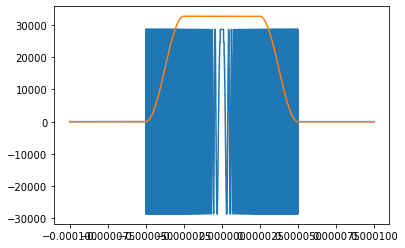

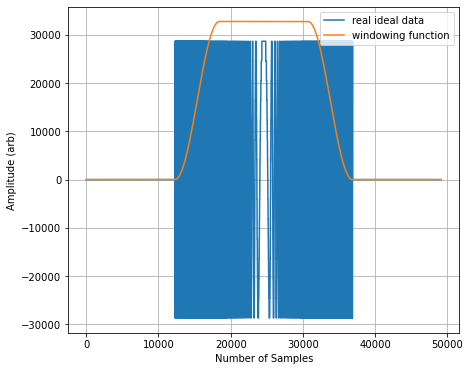

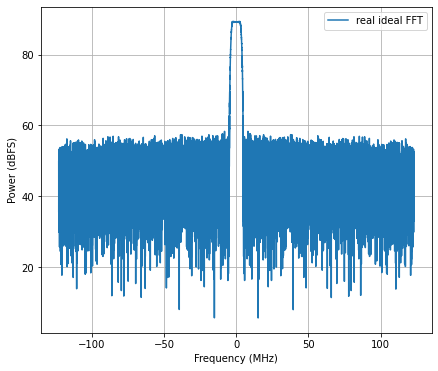

In [22]:
f_ideal, R_ideal, x_data = ideal_chirp.make_ideal_chirp(verbose = True)

In [23]:
T_chirp_actual = ideal_chirp.T_chirp_act

In [24]:
if(hdf5_save_en == True):
    # Save ideal data dataframe and cast to np.int16 
    df_ideal_data = pd.DataFrame(x_data).astype(np.int16)

    # Save ideal data dataframe to the hdf5 file
    hdf5_save.save_df_to_hdf5(df_in = df_ideal_data, hdf5_datafile = hdf5_datafile, title = "Ideal_Chirp_Data")

saved dataframe to Ideal_Chirp_Data table


C:\software\Anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:989: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


### Configure ADRV9009

In [25]:
adrv9009_config = txvr.ADRV9009_Config(ip = "ip:192.168.1.21", f_lo = F_LO, rx_gain = 25, rx_buffer_size = RX_N_sample,
                 tx_gain = -14, calibrate_rx_phase_correction_en = 0, calibrate_rx_qec_en = 0, calibrate_tx_qec_en = 0, 
                 calibrate = 0)

In [26]:
df_adrv9009_config_params = hdf5_save.make_df_from_object_params(adrv9009_config)
if(hdf5_save_en == True):
    hdf5_save.save_df_to_hdf5(df_in = df_adrv9009_config_params, hdf5_datafile = hdf5_datafile, title = "ADRV9009_Data_Collection_params")

saved dataframe to ADRV9009_Data_Collection_params table


Check the LO Frequency

In [27]:
adrv9009_config.sdr.trx_lo

3102000000

### Initialize Trigger Data Class

In [16]:
chirp_trigger = txvr.Trigger_ChirpData(F_sample = RX_sample_rate, F_center = F_center, B_chirp = B_chirp, T_chirp = T_chirp_actual, F_LO = F_center)

### Get ADC data 

In [17]:
data = adrv9009_config.get_ADC_data_RW(data_i = np.real(x_data), data_q = np.imag(x_data))

### Extract chirp data from data_out

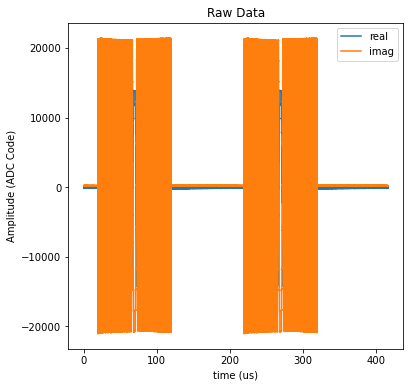

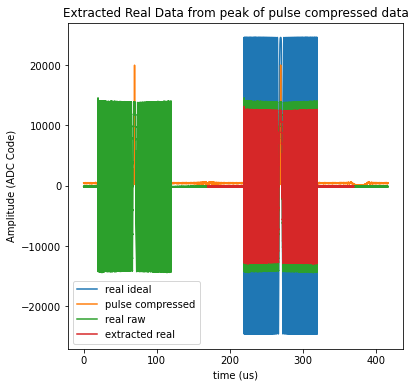

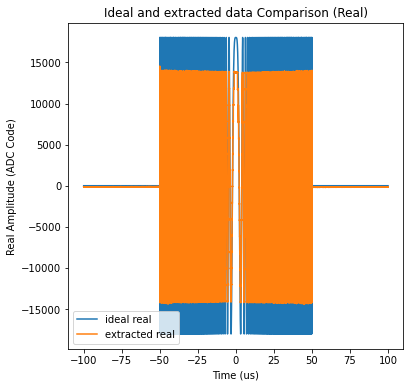

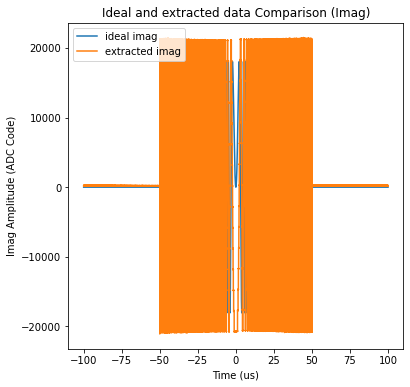

In [18]:
z_real, z_imag, xf, R_out = chirp_trigger.get_onechirp(np.real(data), np.imag(data), True)

In [19]:
###############################################################################
# Uses the the ADRV9009_Config() and the Trigger_ChirpData() classes together to pull
# N amount of time series data from the ADRV9009 Receiver.  Output is data_list - list 
# of lists where each list represents a N_samples of data.  Input is N- the length of the
# amount of data samples to pull, adrv9009_config/chirp_trigger - the vars corresponding to the 
# instantiated ADRV9009_Config()/Trigger_ChirpData().
###############################################################################
def get_N_TriggeredData(N = 10, adrv9009_config = None, chirp_trigger = None, verbose = False):
    data_triggered = []
    data_raw = []
    failed = 0
    
    if(adrv9009_config == None or chirp_trigger == None):
        printf("adrv9009_config or chirp_trigger invalid")

    # Uses a try block because there are instances in which get_onechirp does not succeed in obtaining 
    # N_sample = int(2*T_chirp*F_sample)
    # since the chirp packet might be very near the end of the time series data.  In those instances,
    # I just print failed and try to pull data again.
    while(len(data_triggered) < N):
        
        if(failed > 100):
            print("Failed Threshold Exceeded.  Exiting Now.")
            return -1
        
        try:
            data = adrv9009_config.get_ADC_data_RW(data_i = np.real(x_data), data_q = np.imag(x_data))
            #data = adrv9009_config.get_ADC_data_Read()
            z_real, z_imag, xf, R_out = chirp_trigger.get_onechirp(np.real(data), np.imag(data), verbose)
            data_triggered.append(z_real + 1j*z_imag)
            data_raw.append(data)
        except: 
            failed+=1
    
    print("Boundary Problem encountered ", failed, " times")

    # list of lists with shape 100 x T_chirp*2 in units of samples.  
    # So, I cast data_list to a pandas dataframe and transpose to get the proper form.
    df_trigger = pd.DataFrame(data_triggered).T
    df_data_raw = pd.DataFrame(data_raw).T
        
    return df_trigger, df_data_raw

In [20]:
df_data_extracted, df_data_raw = get_N_TriggeredData(N = 200, adrv9009_config = adrv9009_config, chirp_trigger = chirp_trigger, verbose = False)

Boundary Problem encountered  0  times


In [21]:
if(hdf5_save_en == True):
    raw_data_array = hdf5_save.complex128_to_complexint(df_in = df_data_raw)
    hdf5_save.save_array_data_to_hdf5(nparray_in = raw_data_array, title = "Raw_Data")

C:\Users\mmedrano\Desktop\Waveform_Analysis\Transceiver_ADRV9009_DataCollection.py:785: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if(nparray_in == None):


In [22]:
if(hdf5_save_en == True):
    extracted_data_array = hdf5_save.complex128_to_complexint(df_in = df_data_extracted)
    hdf5_save.save_array_data_to_hdf5(nparray_in = extracted_data_array, title = "Triggered_Data")

In [23]:
df_data_extracted.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-149.000000+233.000000j,-168.000000+237.000000j,-162.000000+228.000000j,-147.000000+229.000000j,-145.000000+214.000000j,-151.000000+229.000000j,-156.000000+210.000000j,-128.000000+242.000000j,-138.000000+188.000000j,-154.000000+222.000000j,...,-152.000000+220.000000j,-162.000000+230.000000j,-179.000000+232.000000j,-145.000000+222.000000j,-151.000000+247.000000j,-157.000000+232.000000j,-173.000000+223.000000j,-176.000000+259.000000j,-157.000000+209.000000j,-156.000000+217.000000j
1,-151.000000+220.000000j,-135.000000+233.000000j,-131.000000+217.000000j,-157.000000+229.000000j,-153.000000+236.000000j,-156.000000+234.000000j,-135.000000+234.000000j,-163.000000+232.000000j,-142.000000+221.000000j,-165.000000+206.000000j,...,-163.000000+228.000000j,-150.000000+232.000000j,-159.000000+248.000000j,-152.000000+216.000000j,-157.000000+235.000000j,-152.000000+223.000000j,-147.000000+244.000000j,-171.000000+267.000000j,-142.000000+232.000000j,-142.000000+208.000000j
2,-138.000000+215.000000j,-147.000000+225.000000j,-155.000000+218.000000j,-154.000000+225.000000j,-167.000000+220.000000j,-155.000000+220.000000j,-145.000000+227.000000j,-142.000000+211.000000j,-138.000000+204.000000j,-134.000000+237.000000j,...,-130.000000+218.000000j,-168.000000+227.000000j,-142.000000+224.000000j,-145.000000+241.000000j,-169.000000+242.000000j,-156.000000+207.000000j,-151.000000+218.000000j,-182.000000+259.000000j,-163.000000+205.000000j,-133.000000+217.000000j
3,-153.000000+241.000000j,-138.000000+209.000000j,-158.000000+237.000000j,-144.000000+243.000000j,-155.000000+231.000000j,-145.000000+241.000000j,-162.000000+238.000000j,-162.000000+237.000000j,-135.000000+210.000000j,-164.000000+235.000000j,...,-146.000000+237.000000j,-150.000000+219.000000j,-156.000000+243.000000j,-170.000000+215.000000j,-165.000000+235.000000j,-155.000000+206.000000j,-153.000000+235.000000j,-169.000000+260.000000j,-139.000000+214.000000j,-151.000000+241.000000j
4,-160.000000+216.000000j,-171.000000+225.000000j,-168.000000+229.000000j,-153.000000+225.000000j,-156.000000+249.000000j,-153.000000+221.000000j,-137.000000+208.000000j,-137.000000+217.000000j,-147.000000+216.000000j,-139.000000+225.000000j,...,-144.000000+235.000000j,-152.000000+229.000000j,-159.000000+245.000000j,-144.000000+218.000000j,-140.000000+241.000000j,-155.000000+230.000000j,-146.000000+227.000000j,-173.000000+254.000000j,-169.000000+212.000000j,-142.000000+223.000000j


In [24]:
df_data_extracted.shape

(49152, 200)

### Incoherent Averaging

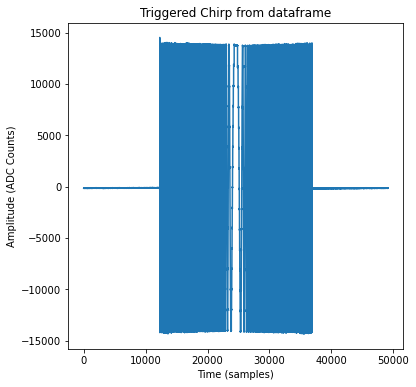

In [25]:
plt.figure(figsize = (6,6))
plt.plot(np.real(df_data_extracted[0]))
plt.ylabel("Amplitude (ADC Counts)")
plt.xlabel("Time (samples)")
plt.title("Triggered Chirp from dataframe")
plt.show()

In [26]:
chirp_avg = txvr.Chirp_average(F_sample = RX_sample_rate, F_center = F_center, B_chirp = B_chirp, T_chirp = T_chirp_actual, F_LO = F_center)

C:\software\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


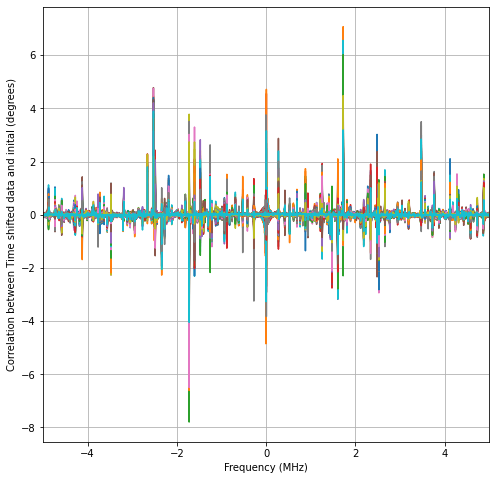

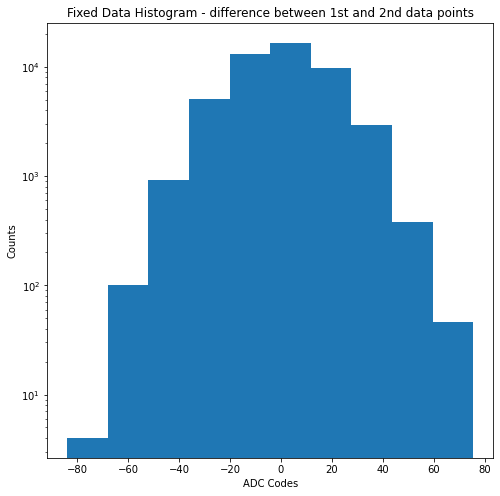

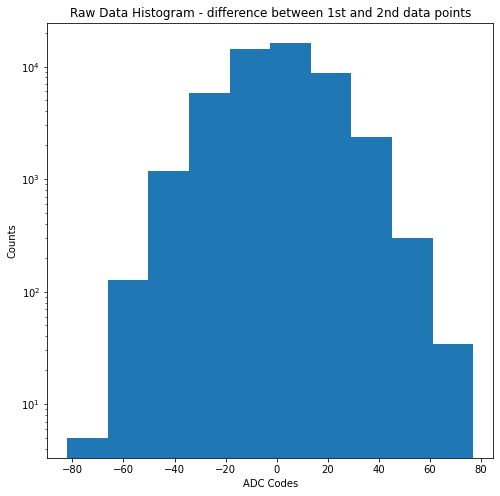

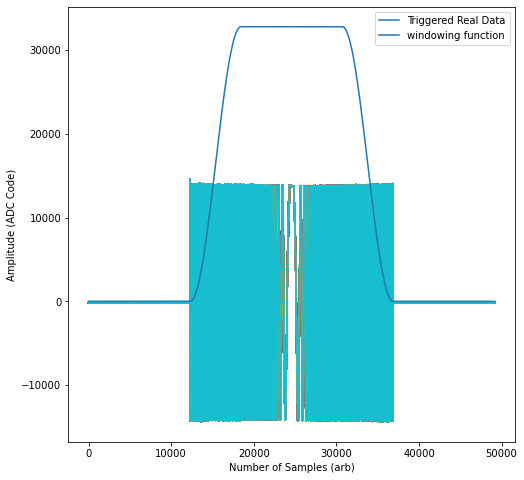

In [27]:
f, R, df_Xfix = chirp_avg.get_chirp_averages(df = df_data_extracted, N_avg = 200, verbose= True)

In [28]:
if(hdf5_save_en == True):
    fixed_data_array = hdf5_save.complex128_to_complexint(df_in = df_Xfix)
    hdf5_save.save_array_data_to_hdf5(nparray_in = fixed_data_array, title = "Fixed_Data")

C:\Users\mmedrano\Desktop\Waveform_Analysis\Transceiver_ADRV9009_DataCollection.py:785: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if(nparray_in == None):


### Plot the averaged data from the ADRV9009

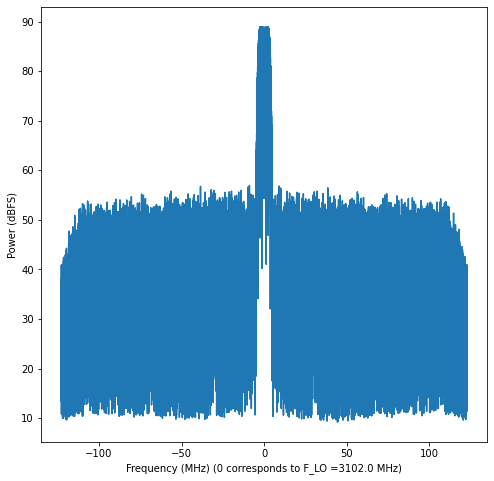

In [29]:
plt.figure(figsize = (8,8))
plt.plot(f, R)
plt.xlabel("Frequency (MHz) (0 corresponds to F_LO =" + str(F_LO/1e6) + " MHz)")
plt.ylabel("Power (dBFS)")
plt.show()

### Plot averaged data from ADRV9009 and ideal data

In [30]:
F_sample = chirp_avg.F_sample/1e6
F_center = chirp_avg.F_center/1e6
f_min = F_center - F_sample/2
f_max = F_center + F_sample/2

In [31]:
f_ideal_mod = f_ideal[(np.abs(f_ideal - f_min)).argmin():(np.abs(f_ideal - f_max)).argmin()] 
R_ideal_mod = R_ideal[(np.abs(f_ideal - f_min)).argmin():(np.abs(f_ideal - f_max)).argmin()]

In [32]:
offset = -10

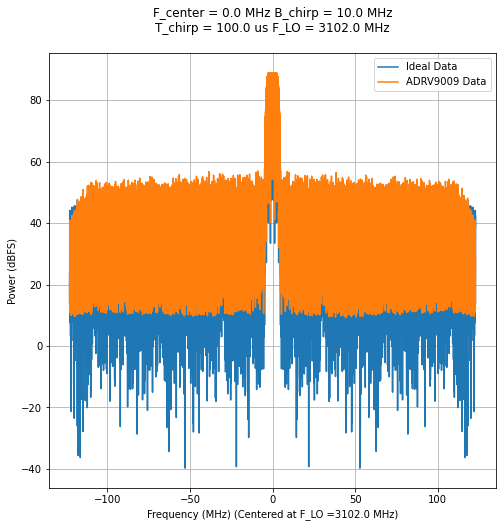

In [33]:
plt.figure(figsize = (8,8))
plt.plot(f_ideal_mod, 10*np.log(R_ideal_mod)/np.log(10)+offset, label="Ideal Data")
plt.plot(f, R, label="ADRV9009 Data")
plt.legend()
plt.title("F_center = " + str(F_center/1e6) + " MHz " + "B_chirp = " + str(B_chirp/1e6) + " MHz\n" +
          "T_chirp = " + str(T_chirp*1e6) + " us" + " F_LO = " + str(F_LO/1e6) + " MHz\n")
plt.xlabel("Frequency (MHz) (Centered at F_LO =" + str(F_LO/1e6) + " MHz)")
plt.ylabel("Power (dBFS)")
plt.savefig("F_LO =" + str(F_LO/1e6) + " MHz.pdf")
plt.grid()
plt.show()